In [1]:
import os
#os.environ["ASE_ABINIT_COMMAND"]="mpirun -np 8 abinit  < PREFIX.files > PREFIX.log"
os.environ["ABINIT_PP_PATH"]="/usr/share/abinit/psp:/usr/share/abinit/psp/HGH:/home/jochym/Projects/abinitio-methods/psp"

In [2]:
%pylab inline
import ase
import ase.io
from ase.build import bulk
from ase.calculators.abinit import Abinit
from ase import units as un
from elastic import get_pressure

# Utility functions
from tqdm.auto import tqdm

Populating the interactive namespace from numpy and matplotlib


In [3]:
def scan_param(cryst, param, start=0, stop=1, steps=7, 
               lista=None, log_scale=True, int_par=False):
    '''
    Scan a range of parameter param and plot 
    '''
    fi = lambda x: x
    fo = lambda x: x

    if lista is None:
        if log_scale :
            fi = log
            fo = exp
        lista = linspace(fi(start), fi(stop), steps)
    else :
        int_par=False
    
    dat = []
    vs = []
        
    for v in lista:
        print(f'{param}={fo(v)}: ', end='')
        if int_par:
            cryst.calc.set(**{param: int(fo(v))})
        else :
            cryst.calc.set(**{param: fo(v)})
        vs.append(fo(v))
        dat.append([cryst.get_potential_energy(),
                    cryst.get_stress()[:3].mean()])
        print(f'{dat[-1][0]:.3f} eV ; {dat[-1][1]/un.GPa:6.3f} GPa',)
    dat = array(dat).T
    return vs, dat

In [4]:
a = 4.38120844

prim = bulk('SiC', crystalstructure='zincblende', a=a, cubic=False)

In [17]:
def create_calculator(label, directory='work_08', ecut=350):
    return Abinit(label=label, directory=directory, v8_legacy_format=True,
              ecut= ecut,
              pps = 'pawxml', pawecutdg = 750, xc = 'GGA',
              toldfe=1.0e-6,
              diemac=12,
              nstep=20,
              kptopt=1,
              ngkpt=[2,2,2],
              nshiftk=1,
              shiftk=[[0.5, 0.5, 0.5]],
              chksymbreak=0,
              )

In [18]:
calc = create_calculator(label='SiC')
prim.set_calculator(calc)

In [19]:
print(f'  Energy:  {prim.get_potential_energy():.3f} eV')
print( '  Stress: [', 6*' %6.2f' % tuple(prim.get_stress()/un.GPa), '] GPa')
print(f'Pressure:     {get_pressure(prim.get_stress())/un.GPa:.3f} GPa')

  Energy:  -265.151 eV
  Stress: [   -0.26  -0.26  -0.26   0.00   0.00   0.00 ] GPa
Pressure:     0.260 GPa


In [20]:
Scan_Corvengence = True

ecut=299.99999999999994: -265.131 eV ;  0.770 GPa
ecut=326.66006663610074: -265.147 eV ;  0.057 GPa
ecut=355.6893304490063: -265.153 eV ; -0.303 GPa
ecut=387.29833462074157: -265.155 eV ; -0.453 GPa
ecut=421.7163326508744: -265.155 eV ; -0.457 GPa
ecut=459.19295108422267: -265.156 eV ; -0.434 GPa
ecut=499.99999999999983: -265.157 eV ; -0.424 GPa


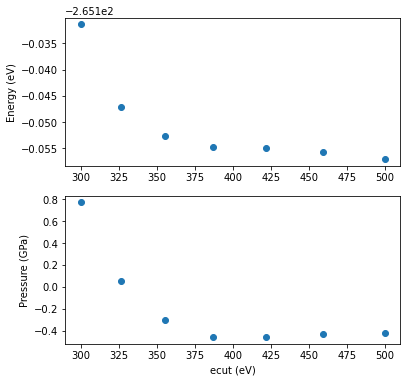

In [21]:
if Scan_Corvengence :
    ecut = prim.calc.parameters['ecut']
    ecuts, eres = scan_param(prim, 'ecut', 300, 500)

    figsize(6,6)
    subplot(211)
    plot(ecuts, eres[0], 'o')
    ylabel('Energy (eV)')
    subplot(212)
    plot(ecuts, eres[1]/un.GPa, 'o')
    ylabel('Pressure (GPa)')
    xlabel('ecut (eV)');
    prim.calc.set(ecut=ecut)

### Basic structure calculation

---


In [32]:
cryst = bulk('SiC', crystalstructure='zincblende', a=a, cubic=True)
cryst = ase.build.sort(cryst, tags=cryst.get_atomic_numbers())
cryst.set_calculator(create_calculator('SiC_UC'))

In [37]:
ase.io.write('work_08/POSCAR', cryst, vasp5=True, direct=True)

In [68]:
cryst.get_forces()

array([[ 0., -0., -0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [-0.,  0.,  0.],
       [-0.,  0., -0.],
       [ 0., -0., -0.],
       [ 0., -0., -0.]])

In [70]:
dsp={}
N = 2
for n in range(N):
    dsp[n] = ase.Atoms(cryst)
    dsp[n].set_calculator(create_calculator(f'SiC_dsp_{n}'))
    dsp[n].rattle(stdev=0.01)

In [74]:
savetxt('work_08/DFSET', 
        [list(x/un.Bohr)+list(f/(un.Rydberg/un.Bohr)) 
         for s in dsp.values() for x, f in zip(s.get_positions()-cryst.get_positions(), 
                         s.get_forces()) ])

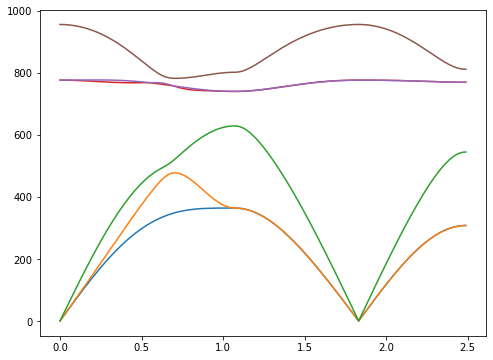

In [75]:
bnd = loadtxt('work_08/CRYST.bands').T
plot(bnd[0], bnd[1:].T);

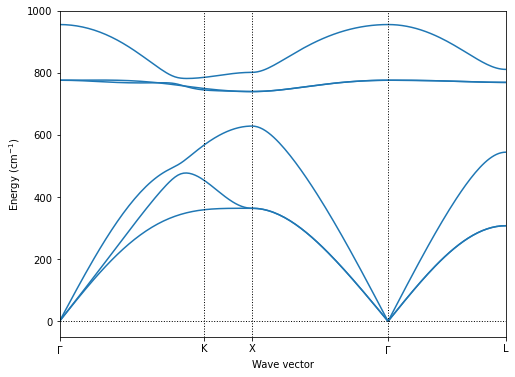

In [76]:
figsize(8,6)
fn = f'work_08/CRYST.bands'
with open(fn, 'r') as df:
    for i, l in enumerate(df):
        if i==0:
            nm = [n.replace('G','$\\Gamma$') for n in l.split()[1:]]
        elif i==1:
            pos = [float(x) for x in l.split()[1:]]
        else :
            break
    pnts = [nm,pos]
d = loadtxt(fn).T
plot(d[0], d[1:].T, color=f'C0', ls='-')


xlim(pnts[1][0], pnts[1][-1])
ylim(bottom=-50, top=1000)
axhline(ls=":", lw=1, color='k')
gca().set_xticks(pnts[1])
gca().set_xticklabels(pnts[0])
for xx in pnts[1][1:-1]:
    axvline(xx, ls=':', lw=1, color='k')
    
ylabel('Energy (cm$^{-1}$)')
xlabel('Wave vector');